## Basic config, package loading

In [8]:
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [9]:
from torch import Tensor
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

sys.path.append('../')
from data_utils import get_train_loader, get_eval_data
from model.unet import get_unet
from trainer.unet_trainer import get_unet_trainer


In [10]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [11]:
import traceback
from typing import List, Union
import threading
from multiprocessing import Process, Queue
from queue import Queue as thrQueue
import numpy as np
import sys
import logging
from multiprocessing import Event
from time import sleep, time
from threadpoolctl import threadpool_limits

try:
    import torch
except ImportError:
    torch = None


def producer(queue, data_loader, transform, thread_id, seed, abort_event, wait_time: float = 0.02):
    print('starting producer')
    np.random.seed(seed)
    data_loader.set_thread_id(thread_id)
    item = None
    print(f'producer set with thread_id {thread_id} and seed {seed}')

    try:
        while True:
            # check if abort event was set
            if not abort_event.is_set():
                # print("worker %d event not set" % thread_id)
                if item is None:
                    try:
                        item = next(data_loader)
                        if transform is not None:
                            print('transforming')
                            item = transform(**item)
                            print('transformed')
                    except StopIteration:
                        item = "end"

                if not queue.full():
                    print('putting item in queue')
                    queue.put(item)
                    item = None
                else:
                    print("queue is full")
                    sleep(wait_time)
            else:
                # print("worder %d event is now set, exiting" % thread_id)
                return
    except KeyboardInterrupt:
        abort_event.set()
        return
    except Exception as e:
        print("Exception in background worker %d:\n" % thread_id, e)
        traceback.print_exc()
        abort_event.set()
        return


def results_loop(in_queues: List[Queue], out_queue: thrQueue, abort_event: Event, pin_memory: bool,
                 gpu: Union[int, None], wait_time: float, worker_list: list):
    do_pin_memory = torch is not None and pin_memory and gpu is not None and torch.cuda.is_available()

    if do_pin_memory:
        print('using pin_memory on device', gpu)
        torch.cuda.set_device(gpu)

    item = None
    queue_ctr = 0
    end_ctr = 0

    while True:
        print('in while loop')
        # if abort_event is set we need to clean up. This is where it hangs sometimes so it makes sense to drain all
        # the incoming queues and ignore all the errors occuring during this process.
        try:
            if abort_event.is_set():
                print("abort event")
                return

            # check if all workers are still alive
            if not all([i.is_alive() for i in worker_list]):
                abort_event.set()
                raise RuntimeError("One or more background workers are no longer alive. Exiting. Please check the print"
                                   " statements above for the actual error message")

            # if we don't have an item we need to fetch it first. If the queue we want to get it from it empty, try
            # again later
            if item is None:
                print('item is None')
                current_queue = in_queues[queue_ctr % len(in_queues)]
                print(len(in_queues))
                if not current_queue.empty():
                    print('queue not empty')
                    # get the item
                    item = current_queue.get()
                    # if we do pin memory, do it now, otherwise skip this
                    if do_pin_memory:
                        if isinstance(item, dict):
                            for k in item.keys():
                                if isinstance(item[k], torch.Tensor):
                                    item[k] = item[k].pin_memory()
                    queue_ctr += 1

                    if isinstance(item, str) and item == 'end':
                        end_ctr += 1
                    if end_ctr == len(in_queues):
                        end_ctr = 0
                        queue_ctr = 0

                else:
                    print('queue empty')
                    sleep(wait_time)
                    continue
            else:
                print(type(item))

            # we only arrive here if item is not None. Now put item in to the out_queue
            if not out_queue.full():
                out_queue.put(item)
                item = None
            else:
                print("out_queue is full, waiting...")
                sleep(wait_time)
                continue
        except KeyboardInterrupt:
            abort_event.set()
            raise KeyboardInterrupt


class MultiThreadedAugmenter(object):
    """ Makes your pipeline multi threaded. Yeah!
    If seeded we guarantee that batches are retunred in the same order and with the same augmentation every time this
    is run. This is realized internally by using une queue per worker and querying the queues one ofter the other.
    Args:
        data_loader (generator or DataLoaderBase instance): Your data loader. Must have a .next() function and return
        a dict that complies with our data structure
        transform (Transform instance): Any of our transformations. If you want to use multiple transformations then
        use our Compose transform! Can be None (in that case no transform will be applied)
        num_processes (int): number of processes
        num_cached_per_queue (int): number of batches cached per process (each process has its own
        multiprocessing.Queue). We found 2 to be ideal.
        seeds (list of int): one seed for each worker. Must have len(num_processes).
        If None then seeds = range(num_processes)
        pin_memory (bool): set to True if all torch tensors in data_dict are to be pinned. Pytorch only.
        timeout (int): How long do we wait for the background workers to do stuff? If timeout seconds have passed and
        self.__get_next_item still has not gotten an item from the workers we will perform a check whether all
        background workers are still alive. If all are alive we wait, if not we set the abort flag.
        wait_time (float): set this to be lower than the time you need per iteration. Don't set this to 0,
        that will come with a performance penalty. Default is 0.02 which will be fine for 50 iterations/s
    """

    def __init__(self, data_loader, transform, num_processes, num_cached_per_queue=2, seeds=None, pin_memory=False,
                 timeout=10, wait_time=0.02):
        self.timeout = timeout
        self.pin_memory = pin_memory
        self.transform = transform
        if seeds is not None:
            assert len(seeds) == num_processes
        else:
            seeds = [None] * num_processes
        self.seeds = seeds
        self.generator = data_loader
        self.num_processes = num_processes
        self.num_cached_per_queue = num_cached_per_queue
        self._queues = []
        self._processes = []
        self._end_ctr = 0
        self._queue_ctr = 0
        self.pin_memory_thread = None
        self.pin_memory_queue = None
        self.abort_event = Event()
        self.wait_time = wait_time
        self.was_initialized = False

    def __iter__(self):
        return self

    def next(self):
        return self.__next__()

    def __get_next_item(self):
        item = None

        while item is None:
            if self.abort_event.is_set():
                self._finish()
                raise RuntimeError("One or more background workers are no longer alive. Exiting. Please check the "
                                   "print statements above for the actual error message")

            if not self.pin_memory_queue.empty():
                item = self.pin_memory_queue.get()
            else:
                
                sleep(self.wait_time)

        return item

    def __next__(self):
        if not self.was_initialized:
            self._start()

        try:
            item = self.__get_next_item()

            while isinstance(item, str) and (item == "end"):
                self._end_ctr += 1
                if self._end_ctr == self.num_processes:
                    self._end_ctr = 0
                    self._queue_ctr = 0
                    logging.debug("MultiThreadedGenerator: finished data generation")
                    raise StopIteration

                item = self.__get_next_item()

            return item

        except KeyboardInterrupt:
            logging.error("MultiThreadedGenerator: caught exception: {}".format(sys.exc_info()))
            self.abort_event.set()
            self._finish()
            raise KeyboardInterrupt

    def _start(self):
        if not self.was_initialized:
            self._finish()
            self.abort_event.clear()

            logging.debug("starting workers")
            self._queue_ctr = 0
            self._end_ctr = 0

            if hasattr(self.generator, 'was_initialized'):
                self.generator.was_initialized = False

            with threadpool_limits(limits=1, user_api='openmp'):
                for i in range(self.num_processes):
                    self._queues.append(Queue(self.num_cached_per_queue))
                    self._processes.append(Process(target=producer, args=(
                        self._queues[i], self.generator, self.transform, i, self.seeds[i], self.abort_event)))
                    self._processes[-1].daemon = True
                    self._processes[-1].start()

            if torch is not None and torch.cuda.is_available():
                gpu = torch.cuda.current_device()
            else:
                gpu = None

            # more caching = more performance. But don't cache too much or your RAM will hate you
            self.pin_memory_queue = thrQueue(max(3, self.num_cached_per_queue * self.num_processes // 2))

            self.pin_memory_thread = threading.Thread(target=results_loop, args=(
                self._queues, self.pin_memory_queue, self.abort_event, self.pin_memory, gpu, self.wait_time,
                self._processes))

            self.pin_memory_thread.daemon = True
            self.pin_memory_thread.start()

            self.was_initialized = True
        else:
            logging.debug("MultiThreadedGenerator Warning: start() has been called but it has already been "
                          "initialized previously")

    def _finish(self, timeout=10):
        self.abort_event.set()

        start = time()
        while self.pin_memory_thread is not None and self.pin_memory_thread.is_alive() and start + timeout > time():
            
            sleep(0.2)

        if len(self._processes) != 0:
            logging.debug("MultiThreadedGenerator: shutting down workers...")
            [i.terminate() for i in self._processes]

            for i, p in enumerate(self._processes):
                self._queues[i].close()
                self._queues[i].join_thread()

            self._queues = []
            self._processes = []
            self._queue = None
            self._end_ctr = 0
            self._queue_ctr = 0

            del self.pin_memory_queue
        self.was_initialized = False

    def restart(self):
        self._finish()
        self._start()

    def __del__(self):
        logging.debug("MultiThreadedGenerator: destructor was called")
        self._finish()


In [12]:
from data_utils import Transforms, MultiImageSingleViewDataLoader, MultiThreadedAugmenter
from dataset import ACDCDataset
from batchgenerators.dataloading.single_threaded_augmenter import SingleThreadedAugmenter
# from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter

def get_heart_train_loader(
    training: str,
    cfg: OmegaConf
):
    """ Instantiates dataloaders for ACDC dataset.
    
    Args:
        training (str): Either 'unet' or 'dae'
        cfg (OmegaConf): data config. For details see wrapper class.

    Returns:
        train_gen (MultiThreadedAugmenter): Training data generator.
        valid_gen (MultiThreadedAugmenter): Validation data generator.
    """
    
    return_orig = True if training == 'dae' else False
    train_transform_key = 'local_transforms' if training == 'dae' else 'all_transforms'
    val_transform_key = 'local_val_transforms' if training == 'dae' else 'io_transforms'

    model_cfg = cfg.unet.heart
    
    transforms = Transforms()
    train_set = ACDCDataset(
        data="train",
        debug=cfg.debug,
        root=cfg.fs.root,
        folder=cfg.data.heart.acdc.data_path
    )
    train_loader = MultiImageSingleViewDataLoader(
        data=train_set,
        batch_size=model_cfg.training.batch_size,
        return_orig=return_orig
    )    
    train_augmentor = transforms.get_transforms(train_transform_key)
    train_gen = MultiThreadedAugmenter(
        data_loader = train_loader,
        transform = train_augmentor,
        num_processes = 1,
        num_cached_per_queue = 1,
        seeds=None
    )
    # train_gen = SingleThreadedAugmenter(
    #     data_loader = train_loader,
    #     transform = train_augmentor,
    #     # num_processes = 1,
    #     # num_cached_per_queue = 1,
    #     # seeds=None
    # )
    
    val_set = ACDCDataset(
        data="val",
        debug=cfg['debug'],
        root=cfg.fs.root,
        folder=cfg.data.heart.acdc.data_path
    )
    valid_loader = MultiImageSingleViewDataLoader(
        data=val_set, 
        batch_size=1,
        return_orig=return_orig
    )
    valid_augmentor = transforms.get_transforms(val_transform_key)
    valid_gen = MultiThreadedAugmenter(
        data_loader = valid_loader, 
        transform = valid_augmentor, 
        num_processes = 1, 
        num_cached_per_queue = 1,
        wait_time=0.2,
        timeout=10,
        pin_memory=False,
        seeds=None
    )
    # valid_gen = SingleThreadedAugmenter(
    #     data_loader = valid_loader, 
    #     transform = valid_augmentor, 
    #     # num_processes = 4, 
    #     # num_cached_per_queue = 2, 
    #     # seeds=None
    # )
    

    return train_gen, valid_gen

In [13]:
cfg.debug = True
# get data
train_loader, val_loader = get_heart_train_loader(
    training='dae', 
    cfg=cfg
)

loading dataset
loading all case properties
loading dataset
loading all case properties


In [14]:
test = next(train_loader)

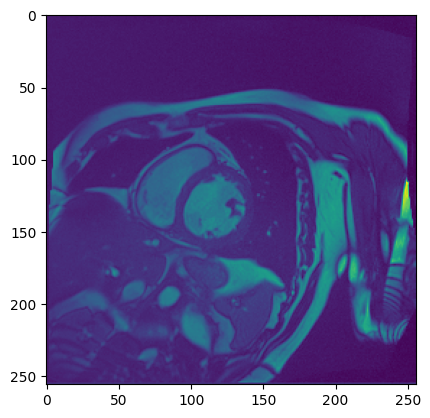

In [25]:
plt.imshow(test['data'][2, 0, :, :])

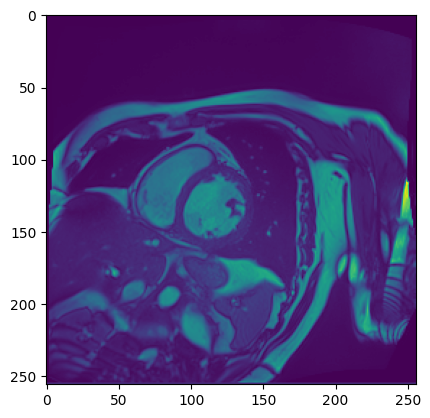

In [26]:
plt.imshow(test['data_orig'][2, 0, :, :])

## Model selection

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr

unet_name = 'default-8'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()


## Everything Data

In [4]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = True

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties


loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties


KeyboardInterrupt: 

In [ ]:
test

In [8]:
cfg.wandb.log = False
# get trainer
trainer = get_unet_trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    model=unet,
    cfg=cfg
)

In [6]:
## Sanity Check if config is as expected
print(OmegaConf.to_yaml(cfg))

debug: true
wandb:
  log: true
  project: MICCAI2023-extension
fs:
  root: ../../
data:
  brain:
    data_path: data/conp-dataset/projects/calgary-campinas/CC359/Reconstructed/
  heart:
    data_path: data/mnm/
unet:
  brain:
    pre: calgary_unet
    n_chans_in: 1
    n_filters_init: 8
    n_chans_out: 1
    training:
      save_loc: pre-trained
      train_site: 6
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      epochs: 250
      patience: 4
      lr: 0.001
  heart:
    pre: monai-64-4-4
    n_chans_in: 1
    n_filters_init: 64
    n_chans_out: 4
    training:
      save_loc: pre-trained
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      num_val_batches_per_epoch: 50
      epochs: 250
      patience: 4
      lr: 0.001
    arch: monai
    depth: 4
    num_res_units: 4
run:
  iteration: 0
  data_key: heart
eval:
  data:
    training: true
    validation: true
    testing: all
    s

## General Eval Pipeline

In [7]:

#####################################################
### From eval.unet_test. Modify to fit your needs ###
#####################################################

from typing import Dict
from omegaconf import OmegaConf
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from utils import  epoch_average
from losses import (
    DiceScoreCalgary, 
    DiceScoreMMS
)



def get_df_from_dict(
    cfg: OmegaConf,
    metrics: Dict
):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    df['Iteration'] = cfg.run.iteration
    df['Model'] = cfg.unet[cfg.run.data_key].pre
    df['Data'] = cfg.run.data_key

    return df


def eval_set(
    cfg: OmegaConf,
    model: nn.Module,
    dataset: Dataset
) -> Dict:
    if cfg.run.data_key == 'brain':
        dataset.volume_wise = True
        dataloader = DataLoader(
            dataset,
            batch_size=32,
            shuffle=False,
            drop_last=False
        )
        eval_metrics = {
            'Volumetric Dice': DiceScoreCalgary(),
            # Surface Dice is not defined for fragmented volumes, which we get
            # by subsetting above. The original eval function in
            # eval.unet_test does support surface Dice but not subsetting.
            # 'Surface Dice': SurfaceDiceCalgary() 
        }
        metrics = eval_brain_set(
            model=model, 
            dataloader=dataloader, 
            eval_metrics=eval_metrics
        )

    elif cfg.run.data_key == 'heart':
        dataloader = DataLoader(dataset, 
            batch_size=32, 
            shuffle=False, 
            drop_last=False
        )
        eval_metrics = {
            "Volumetric Dice": DiceScoreMMS()
        }
        metrics = eval_heart_set(
            model=model, 
            dataloader=dataloader, 
            eval_metrics=eval_metrics
        )
    
    else:
        raise ValueError(
            f'Invalid data key. No dataset named {cfg.run.data_key}'
        )

    return metrics



@torch.no_grad()
def eval_brain_set(
    model: nn.Module, 
    dataloader: DataLoader, 
    eval_metrics: Dict
) -> Dict:
    model.eval()
    batch_sizes = []
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        net_out = model(input_.cuda()).detach().cpu()
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(metric(net_out,target).detach().mean().cpu())

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)

    return epoch_metrics



@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
    eval_metrics: Dict
) -> Dict:
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    # saves batch sizes for each batch for averaging
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].cuda()
        # convert -1 labels to background
        target[target == -1] = 0
        # convert to one-hot encoding
        target = F.one_hot(
            target.long(), 
            num_classes=4
        ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out = model(input_.cuda())
        
        batch_sizes.append(input_.shape[0])
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(
                metric(net_out, target).detach().mean().cpu()
            )
            
    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
        
    return epoch_metrics

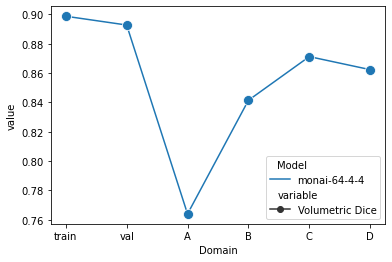

In [8]:
metrics = {}

for key in data.keys():
    metrics[key] = eval_set(
        cfg=cfg,
        model=unet,
        dataset=data[key]
    )

df = get_df_from_dict(cfg, metrics)

sns.lineplot(
    data=df, 
    x='Domain', 
    y='value', 
    hue='Model',
    style='variable',
    markers=True, 
    dashes=False, 
    markersize=10, 
    marker='x'
)
plt.show()

## Image selection and analysis

In [9]:
# select single image
print(f'\nAvailable datasets are:')
for key in data:
    print(f'  {key}: {len(data[key])} images')


domain = 'A'
idx    = 20
image, seg_mask, voxel_spacing = data[domain][idx].values()


Available datasets are:
  train: 50 images
  val: 50 images
  A: 50 images
  B: 50 images
  C: 50 images
  D: 50 images


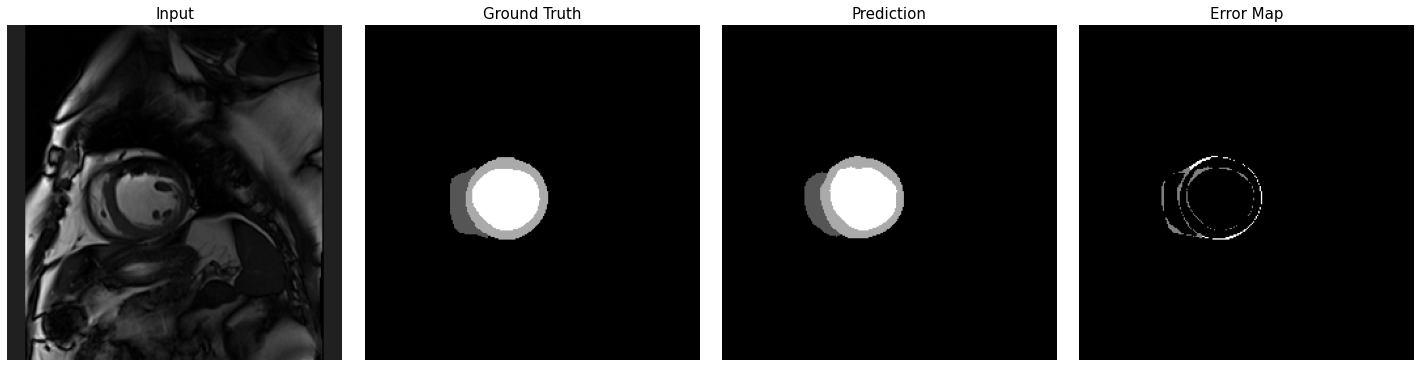

In [10]:


# segment image
with torch.no_grad():
    net_out = unet(image.unsqueeze(0).cuda()).detach().cpu()
    if DATA_KEY == 'brain':
        prediction = (net_out[0] > 0.5) * 1
    elif DATA_KEY == 'heart':
        prediction = net_out.argmax(1)
    error_map = (seg_mask - prediction).abs()


# plot results
def plot_side_by_side(
    images: List[Tensor], 
    titles: List[str] = None, 
    cmap: str = 'gray'
):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))
    
    if n == 1:  # If only one image, wrap axes in a list to make iterable
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=cmap)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i], fontsize=15)
        
    plt.tight_layout()
    return fig


fig = plot_side_by_side(
    images = [
        image[0], 
        seg_mask[0], 
        prediction[0], 
        error_map[0],
    ], 
    titles = [
        'Input', 
        'Ground Truth', 
        'Prediction',
        'Error Map',
    ]  # comment to hide titles
)